In [1]:
import os
from itertools import zip_longest

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from utils.mushrooms import get_train_data, get_test_dataloader, get_train_dataloader
from utils.model import LogisticRegression
from utils.optim import GD
from utils.worker import setup_workers, update_worker_models
# from utils.worker import setup_workers
from utils.accuracy import compute_accuracy_mushrooms

graphs_dir = "./graphs"
os.makedirs(graphs_dir, exist_ok=True)
train_dataset = get_train_data()

In [2]:
global_model = LogisticRegression(input_size=train_dataset.X.shape[1], num_classes=1).double()
criterion = nn.BCEWithLogitsLoss()
optimizer = GD(global_model.parameters(), lr=0.1, weight_decay=0.1)

testloader = get_test_dataloader()
num_workers = 1
workers = setup_workers(
    #original_model=LogisticRegression(input_size=train_dataset.X.shape[1], num_classes=1),
    original_model=global_model,
    criterion=nn.BCEWithLogitsLoss(),
    dataset=train_dataset, 
    num_workers=num_workers,
    batch_size=train_dataset.X.shape[0]//num_workers + 1
)


In [3]:
def get_grad(model):
    return dict(global_model.named_parameters())['classifier.weight'].grad.detach()

In [4]:
# num_epochs = 1000
# accuracies = []
# grads = []
# losses = []
# train_loader = get_train_dataloader()
# model = global_model

# for epoch in range(num_epochs):
#     # print(f"Starting epoch {epoch+1}")
#     optimizer.zero_grad()
#     output = model(train_dataset.X)
#     loss = criterion(output, train_dataset.y)
#     loss.backward()

#     corrected_gradients = {}
#     # with torch.no_grad():
#     for name, param in model.named_parameters():
#         if param.grad is not None:
#             corrected_gradients[name] = param.grad

#     num_grads = 0
#     for name, param in global_model.named_parameters():
#         if corrected_gradients[name] is not None:
#             if param.grad is None:
#                 param.grad = corrected_gradients[name] / num_grads
#             else:
#                 param.grad += corrected_gradients[name] / num_grads
#     # accuracies.append(compute_accuracy_mushrooms(global_model, train_dataset))
#     grads.append(torch.norm(dict(global_model.named_parameters())['classifier.weight'].grad.detach()))
#     losses.append(loss.detach())
#     optimizer.step()

#     params = {}
#     for name, param in global_model.named_parameters():
#         params[name] = param.clone().detach()
#     for name, param in model.named_parameters():
#         param = params[name]

# # grads = [torch.norm(g1-g2) for g1,g2 in zip(grads[1:],grads[:-1])]

# plt.figure(figsize=(7, 4))
# plt.semilogy(grads)
# plt.xlabel("Epoch")
# plt.ylabel("norm of grad")
# plt.title("norm of grad vs. Epoch")
# plt.grid(True)
# plt.show()

# # plt.figure(figsize=(7, 4))
# # plt.plot(accuracies)
# # plt.xlabel("Epoch")
# # plt.ylabel("Accuracy")
# # plt.title("Accuracy vs. Epoch")
# # plt.grid(True)
# # plt.show()

# plt.figure(figsize=(7, 4))
# plt.semilogy(losses)
# plt.xlabel("Epoch")
# plt.ylabel("loss")
# plt.title("loss vs. Epoch")
# plt.grid(True)
# plt.show()



In [5]:
train_dataset.X.requires_grad

False

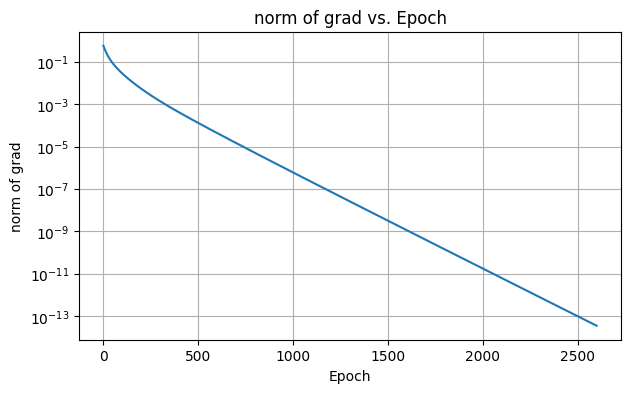

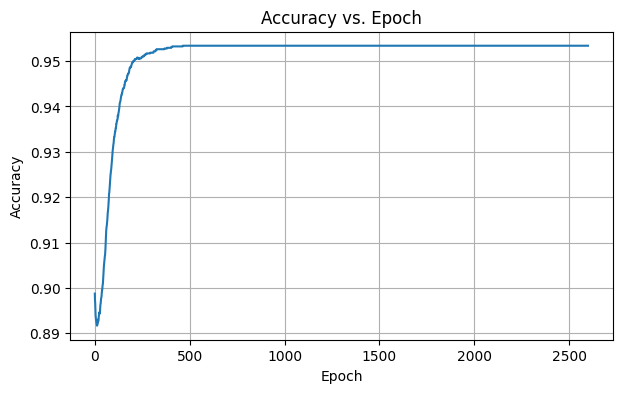

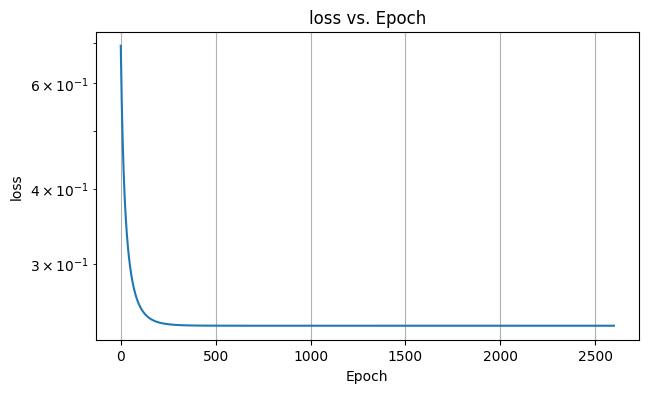

In [6]:
num_epochs = 2600
accuracies = []
grads = []
losses = []
model = global_model

for epoch in range(num_epochs):
    # print(f"Starting epoch {epoch+1}")
    
    optimizer.zero_grad()
    output = model(train_dataset.X)
    loss = criterion(output, train_dataset.y)
    loss.backward()
    optimizer.step()

    accuracies.append(compute_accuracy_mushrooms(global_model, train_dataset))
    grads.append(torch.norm(dict(global_model.named_parameters())['classifier.weight'].grad))
    losses.append(loss.detach())

# grads = [torch.norm(g1-g2) for g1,g2 in zip(grads[1:],grads[:-1])]

plt.figure(figsize=(7, 4))
plt.semilogy(grads)
plt.xlabel("Epoch")
plt.ylabel("norm of grad")
plt.title("norm of grad vs. Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("loss vs. Epoch")
plt.grid(True)
plt.show()



In [7]:
# num_epochs = 1000
# accuracies = []
# grads_hist = []
# train_loader = get_train_dataloader()

# for epoch in range(num_epochs):
#     # print(f"Starting epoch {epoch+1}")
#     update_worker_models(workers, global_model)
#     for grads_tuple in zip_longest(*[worker.gradient_generator() for worker in workers]):
#         optimizer.zero_grad()
#         num_grads = sum(1 for _ in filter(None, grads_tuple))
#         if num_grads == 0:
#             continue
#         for grads in filter(None, grads_tuple):
#             for name, param in global_model.named_parameters():
#                 if grads[name] is not None:
#                     if param.grad is None:
#                         param.grad = grads[name] / num_grads
#                     else:
#                         param.grad += grads[name] / num_grads
#         accuracies.append(compute_accuracy_mushrooms(global_model, train_dataset))
#         grads_hist.append(torch.norm(dict(global_model.named_parameters())['classifier.weight'].grad))
#         optimizer.step()
#         update_worker_models(workers, global_model)
    

# plt.figure(figsize=(7, 4))
# plt.semilogy(grads_hist)
# plt.xlabel("Epoch")
# plt.ylabel("norm of grad")
# plt.title("norm of grad vs. Epoch")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(7, 4))
# plt.plot(accuracies)
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Accuracy vs. Epoch")
# plt.grid(True)
# plt.show()

